see: https://huggingface.co/facebook/detr-resnet-101-dc5

fine tuning: https://huggingface.co/docs/transformers/main/en/tasks/object_detection

removed 3 boxes
detected person with confidence 0.998 at location [186.37, 581.06, 235.74, 638.99]
detected person with confidence 0.994 at location [138.45, 588.62, 173.89, 638.97]
detected person with confidence 0.992 at location [85.28, 586.73, 108.16, 614.55]
detected person with confidence 0.987 at location [357.41, 584.12, 383.91, 613.26]
detected person with confidence 0.986 at location [169.24, 581.93, 194.47, 623.85]
detected boat with confidence 0.922 at location [75.22, 113.63, 495.7, 670.12]
detected person with confidence 0.906 at location [384.05, 571.75, 408.04, 611.87]
detected boat with confidence 0.808 at location [78.55, 198.97, 318.77, 663.44]
detected person with confidence 0.806 at location [76.49, 586.98, 92.32, 612.03]
detected person with confidence 0.719 at location [152.65, 596.05, 180.36, 631.9]
detected person with confidence 0.668 at location [77.39, 587.41, 99.21, 622.32]
detected boat with confidence 0.474 at location [77.44, 587.73, 114.04, 632.11]
dete

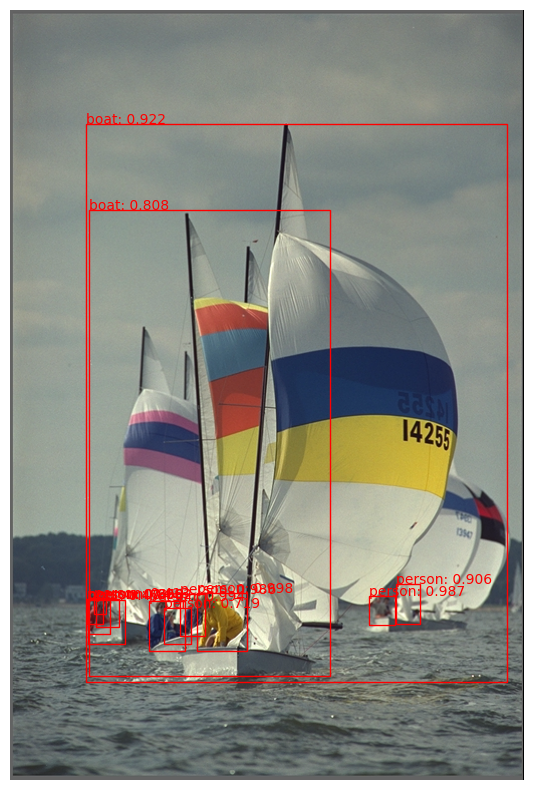

In [8]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
from torchvision.ops import boxes as box_ops

# read in img
filename =  f'kodim{random.randint(1, 24):02d}.png'
imgpath = Path.cwd().parent.parent / 'data' / 'kodak' / filename
assert imgpath.exists(), f'Image not found at {imgpath}'
image = Image.open(imgpath)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
min_confidence = 0.4
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=min_confidence)[0]

# apply non-maximum suppression to remove overlapping boxes
keep = box_ops.batched_nms(results["boxes"], results["scores"], results["labels"], 0.5)
print(f"nms optimization: removed {len(results['scores']) - len(keep)} boxes")
results = {key: (val[keep]) for key, val in results.items()}

# plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.axis("off")

GREEN = "\033[92m"
RESET = "\033[0m"
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(f"detected {GREEN}{model.config.id2label[label.item()]}{RESET} with confidence {round(score.item(), 3)} at location {box}")

    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(box[0], box[1], f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}", color="red")

ax.imshow(image)
plt.show()


# alternatively

In [4]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-101-dc5')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-101-dc5')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

print(logits.shape, bboxes.tensor.shape)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

Some weights of the model checkpoint at facebook/detr-resnet-101-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'Tensor' object has no attribute 'tensor'